In [1]:
import os
import sys
parent_dir = os.path.join(os.getcwd(), '..')
if parent_dir not in sys.path: sys.path.append(parent_dir)
from utility import *
from mkit.torch_support.nn_utils import training_loop

In [2]:
import matplotlib.pyplot as plt

In [3]:
files = get_files("../Travel-Itinerary-Datasets-for-Japan-and-Taiwan-sourced-from-Ptt")
return_list = []
file = files[0]
path_name = process_and_transform_data(file, resolution=.5, overwrite=True)
with open(path_name, 'rb') as f:
    result_dict = pickle.load(f)
labels = result_dict['labels']
encoder = result_dict['encoder']
MAX_LEN = result_dict['max length']
file_name = result_dict['file name']
WIDTH = result_dict['width']
HEIGHT = result_dict['height']
WIDTH, HEIGHT

original dataset size: 238
dataset size with duplicates removed: 172


(48, 64)

In [4]:
x_list = []
y_list = []
y_seq_list = []
y_one_hot_list = []
for observation in labels:
    unique_values = np.unique(observation)[1:]
    if len(unique_values) == 1: continue
    unique_values = np.sort(unique_values)

    half = len(unique_values) // 2
    x = deepcopy(observation)
    y = deepcopy(observation)
    y_seq = []
    y_one_hot = deepcopy(observation)
    y_one_hot[np.where(y_one_hot != 0)] = 1
    for val in unique_values:
        index = np.where(observation == val)
        coor = encoder.single_transform(tuple([index[0][0], index[1][0]]))
        if val > half:
            x[index] = 0
            y_seq.append(coor)
            
        else:
            x[index] = 1
            y_one_hot[index] = 0
            y[index] = 0
    y = y / max(unique_values)
    y_seq += [0] * (MAX_LEN - len(y_seq))

    y_one_hot = y_one_hot.flatten()
    x_list.append(x)
    y_list.append(y)
    y_one_hot_list.append(y_one_hot)
    y_seq_list.append(y_seq)
    

In [5]:
from mkit.torch_support.tensor_utils import xy_to_tensordataset
loader, val_loader, test_loader = xy_to_tensordataset(
    np.expand_dims(np.array(x_list), 1), np.expand_dims(np.array(y_list), 1),
    return_loader=True, 
    batch_size=8,
    input_dtype=torch.float32,
    output_dtype=torch.float32,
    val_ratio=.15,
    test_ratio=.15
)

In [6]:
import torch
from torch import nn
class AE(nn.Module):
    def __init__(
            self, 
            input_dim=1, 
            start_dim=32,
            number_of_layers = 3,
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        ):
        super(AE, self).__init__()
        self.encoder = [self._block(input_dim, start_dim)]
        current_dim = start_dim
        for i in range(number_of_layers - 1):
            self.encoder.append(self._block(current_dim, current_dim // 2))
            current_dim //= 2
        self.decoder = []
        for i in range(number_of_layers - 1):
            self.decoder.append(self._block(current_dim, current_dim * 2))
            current_dim *= 2
        self.decoder.append(nn.Conv2d(current_dim, input_dim, padding=1, kernel_size=3))
        self.encoder = nn.Sequential(*self.encoder)
        self.decoder = nn.Sequential(*self.decoder)
        self.to(device)
        self.device = device
    def _block(self, input_dim, output_dim):
        return nn.Sequential(
            nn.Conv2d(input_dim, output_dim, padding=1, kernel_size=3),
            nn.BatchNorm2d(output_dim),
            nn.LeakyReLU(.2)
        )
    def forward(self, x):
        x = x.to(self.device)
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
ae = AE()
class weighted_loss(nn.Module):
    def __init__(self):
        super(weighted_loss, self).__init__()
    def forward(self, pred, true, weight=1):
        weights = torch.where(true != 0, weight, .01)
        return torch.mean(weights * torch.abs(pred - true))
model, train_losses, val_losses = training_loop(
    model=ae,
    train_loader=loader,
    val_loader=val_loader,
    epochs=10,
    device=ae.device,
    criterion=weighted_loss(),
    optimizer=torch.optim.Adam(ae.parameters(), lr=1e-3),
    keep_losses=True
)



EPOCH 1/10: 100%|██████████| 15/15 [00:00<00:00, 16.21it/s]


Epoch [1/10] Training Loss: 0.0014  Validation Loss: 0.0008



EPOCH 2/10: 100%|██████████| 15/15 [00:00<00:00, 66.83it/s]


Epoch [2/10] Training Loss: 0.0008  Validation Loss: 0.0005



EPOCH 3/10: 100%|██████████| 15/15 [00:00<00:00, 63.10it/s]


Epoch [3/10] Training Loss: 0.0007  Validation Loss: 0.0006



EPOCH 4/10: 100%|██████████| 15/15 [00:00<00:00, 73.67it/s]


Epoch [4/10] Training Loss: 0.0006  Validation Loss: 0.0004



EPOCH 5/10: 100%|██████████| 15/15 [00:00<00:00, 72.26it/s]


Epoch [5/10] Training Loss: 0.0005  Validation Loss: 0.0004



EPOCH 6/10: 100%|██████████| 15/15 [00:00<00:00, 73.66it/s]


Epoch [6/10] Training Loss: 0.0004  Validation Loss: 0.0005



EPOCH 7/10: 100%|██████████| 15/15 [00:00<00:00, 70.66it/s]


Epoch [7/10] Training Loss: 0.0004  Validation Loss: 0.0005



EPOCH 8/10: 100%|██████████| 15/15 [00:00<00:00, 72.60it/s]


Epoch [8/10] Training Loss: 0.0004  Validation Loss: 0.0005



EPOCH 9/10: 100%|██████████| 15/15 [00:00<00:00, 67.57it/s]


Epoch [9/10] Training Loss: 0.0004  Validation Loss: 0.0005



EPOCH 10/10: 100%|██████████| 15/15 [00:00<00:00, 73.83it/s]

Epoch [10/10] Training Loss: 0.0004  Validation Loss: 0.0005

Training complete.


In [7]:
# pred[0][0]

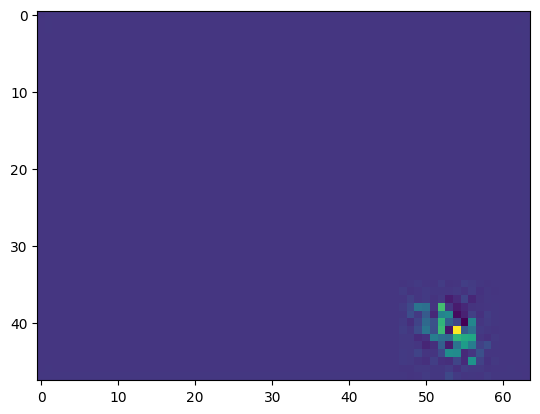

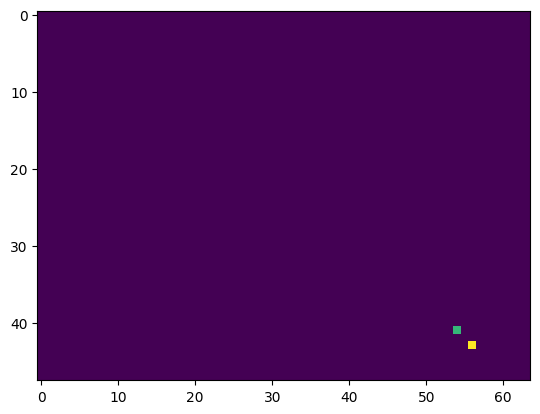

In [8]:
test_x, test_y = next(iter(test_loader))
pred = ae(test_x).detach().cpu()

plt.imshow(pred[1][0])
plt.show()
plt.imshow(test_y[1][0])
plt.show()